In [1]:
# Import required packages
import pickle
from pathlib import Path
from collections import defaultdict
from itertools import cycle, permutations
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gaussian_kde

In [2]:
# Silence unwanted warning messages
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
#Import MOFNet (ACS Appl. Mater. Interfaces 2021, 13, 20, 23647–23654)
from mofnet import DataLoader, MOFNet


mofnet = MOFNet()
mofnet.initialize_weights()


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
# Load trained MOFNet for hydrogen working capacity prediction

mofnet.load_weights("mofnet-gen_3-min.h5")

In [5]:
# Prepare working capacity database from raw GCMC database
pressures = [
  1,2,5,10,20,30,35,40,50,60,70,80,90,100
]

names = ["key"] + [str(p) for p in pressures]

uptake_data_paths = [
    "gen_3.txt",
]

wc_data_list = []
for path in uptake_data_paths:
    data = pd.read_table(path, index_col=0, header=None, names=names, sep="\s+")
    data = data["100"] - data["5"]
    wc_data_list.append(data)
wc_data = pd.concat(wc_data_list)

[len(data) for data in wc_data_list]

[130606]

In [6]:
# Normalize working capacity. Scale working capacity into [0,1]
data = wc_data.copy() / 100.0

In [7]:
# Extract test dataset for the prediction
fraction = 0.1
test_data = data.sample(frac=fraction)

test_data.describe()

count    13061.000000
mean         0.284552
std          0.085402
min         -0.000076
25%          0.261460
50%          0.317065
75%          0.340507
max          0.397693
dtype: float64

In [8]:
# Load data loader.
data_loader = DataLoader.from_state("data_loader_state-20200116.npz")

test_set = data_loader.make_dataset(
               np.array(test_data.index, dtype=str),
               np.array(test_data),
               batch_size=1000,
               repeat = False,
               shuffle = False,
           )

print(test_set)

<BatchDataset shapes: (<unknown>, <unknown>), types: (tf.int32, tf.float32)>


In [9]:
# Make prediction
y_pred = []
for x, y in test_set:
    _y = mofnet(x)
    y_pred += _y.numpy().reshape(-1).tolist()
y_pred = np.array(y_pred)

In [10]:
# Rescale
x = test_data*100
y = np.array(y_pred)*100

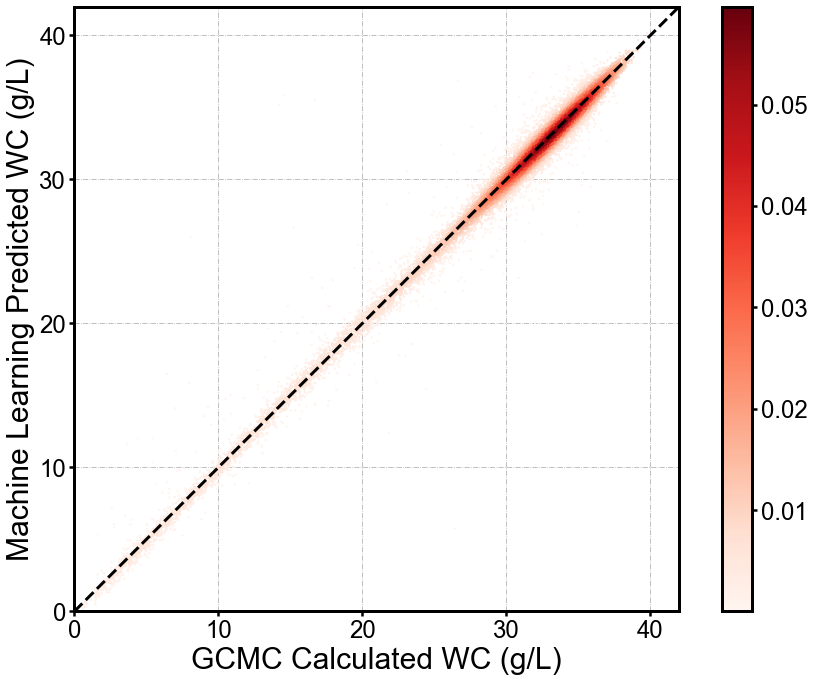

In [11]:
#Draw parity plot

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size']=24
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2.5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2.5
mpl.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.axisbelow'] = True

fig, ax = plt.subplots(1,1, figsize=(13, 10))

T = np.array([x, y])
color = gaussian_kde(T)(T)

im = plt.scatter(x,y, c=color, cmap='Reds',s=2)
ax.set_aspect('equal')

plt.plot([0, 42], [0, 42], c="black", linewidth=3, linestyle='--')
plt.colorbar(im)

plt.yticks([0,10,20,30,40],fontsize=24)
plt.xticks([0,10,20,30,40], fontsize=24)

plt.tick_params(axis='both', labelsize=24)

plt.tick_params(labelsize=24)

plt.xlabel('GCMC Calculated WC (g/L)', fontsize = 30)
plt.ylabel('Machine Learning Predicted WC (g/L)', fontsize = 30)

plt.grid(axis='both',linestyle='-.')

plt.xlim(xmin=0,xmax=42)
plt.ylim(ymin=0,ymax=42)

plt.tight_layout()
